In [1]:
!git clone https://github.com/elenanespolo/Sentiment_Sarcasm_Analysis

%cd Sentiment_Sarcasm_Analysis
!git pull

Cloning into 'Sentiment_Sarcasm_Analysis'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 315 (delta 31), reused 34 (delta 15), pack-reused 255 (from 1)
Receiving objects: 100% (315/315), 18.20 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (164/164), done.
Filtering content: 100% (11/11), 27.24 MiB | 24.66 MiB/s, done.
/content/Sentiment_Sarcasm_Analysis
Already up to date.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import transformers
import tqdm
from transformers import BertConfig, BertModel, BertTokenizer
from transformers.models.bert.modeling_bert import BertLayer, BertEncoder
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from sklearn.metrics import f1_score

pcgrad_repo = "./pcgrad_repo"
if not os.path.exists('./pcgrad_repo'):
    !git clone https://github.com/WeiChengTseng/Pytorch-PCGrad
    !mv Pytorch-PCGrad pcgrad_repo
from pcgrad_repo.pcgrad import PCGrad

# !pip install bitsandbytes
# quantization dependency (may need other dependencies that i forgot)

from peft import LoraConfig, get_peft_model, TaskType # LoRA imports (may need to add the pip install)


Cloning into 'Pytorch-PCGrad'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 133 (delta 24), reused 22 (delta 22), pack-reused 105 (from 1)
Receiving objects: 100% (133/133), 563.81 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Set parameters

In [38]:
ENABLE_WANDB = True
training_dataset_name = 'bicodemix'  # 'BESSTIE' or 'yelp' or 'bicodemix' or 'twitter'

use_decoder = False  # if True use decoder otherwise use classification head on top of encoder

use_spAtten = True # if True ...

#NOTE: sentiment always first in 'task' field (index 0), sarcasm second (index 1) where not in dictionary
#NOTE: task always lowercase, but check is always done
#NOTE: class '0' (negative) always first in classes list (index 0), class '1' (positive) second (index 1), etc.
#NOTE: if a task is not present, its classes list is empty (lenght of 0 not None)
#NOTE: BESSTIE dataset apply filter base on value of 'task', 'variety' and 'source' fields,
# if None, no filter applied for that field, only sample with correct values for that field are kept
# if task is 'sentiment' only sample with at least sentiment labels are kept,
# if 'sarcasm', only samples with at least sarcasm labels are kept
# EXAMPLE: task = 'sentiment', variety = 'en-IN', source = 'Reddit' means:
# keep only samples with sentiment labels not nan, variety 'en-IN' and source 'Reddit'

#TODO: check yelp dataset if compatible
#TODO: implement outomatic way to set min_length and max_length based on dataset statistics
#TODO: implement for bicodemix selection of task other than sarcasm-sentiment
train_dataset_CFGs = {
    'BESSTIE':{
        'dataset_name': 'BESSTIE',
        'root_folder': './dataset/besstie',
        'file_name': 'train_SS_with_nan.csv',
        'classes': {
            'sentiment': ['0', '1'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sentiment',
        'variety': 'en-IN',
        'source': 'Reddit',
    },
    'yelp': {
        'dataset_name': 'yelp',
        'root_folder': './dataset/yelp',
        'file_name': 'yelp_filtered_reviews.csv',
        'classes': {
            'sentiment': ['useful', 'funny', 'cool'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    },
    'bicodemix': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': ['0', '1', '2'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sarcasm-sentiment',
    },
    'bicodemix_sarcasm': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': [],
            'sarcasm': ['0', '1'],
        },
        'task': 'sarcasm',
    },
    'bicodemix_sentiment': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': ['0', '1', '2'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    },
    'twitter': {
        'dataset_name': 'twitter',
        'root_folder': './dataset/twitter',
        'file_name': 'twitter_sentiment_analysis.csv',
        'classes': {
            'sentiment': ['Negative', 'Positive'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    }
}

valid_dataset_CFG = {
    'dataset_name': 'BESSTIE',
    'root_folder': './dataset/besstie',
    'file_name': 'valid_SS_with_nan.csv',
    'classes': {
        'sentiment': ['0', '1'],
        'sarcasm': ['0', '1'],
    },
    'task': train_dataset_CFGs[training_dataset_name]['task'],
    'variety': None,
    'source': None,
}

# TODO: validate parameters
QUANTIZATION_CFG = {
    'load_in_4bit': True,
    'bnb_4bit_quant_type': "nf4",
    'bnb_4bit_compute_dtype': torch.float16,
}

# TODO: validate parameters
LORA_CFG = {
    'r': 16,
    'lora_alpha': 32,
    'target_modules': ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    'lora_dropout': 0.1,
    'bias': "none",
    'task_type': None # TaskType.CAUSAL_LM
}

CFG = {
    'lr': 2e-5,
    'start_epoch': 30,
    'epochs': 30,
    'batch_size': 8,
    'max_length': 200,
    'min_length': 1,
    "train_dataset_CFG": train_dataset_CFGs[training_dataset_name],
    "valid_dataset_CFG": valid_dataset_CFG,
    'model_name': 'bert-base-uncased',
    'classification_head': 'cross_talk_conv', # ['linear', 'conv', 'lstm', 'multi_task_conv', 'cross_talk_conv']
    'quantization_config': QUANTIZATION_CFG,
    'lora_config': LORA_CFG,
    'seed': 0,
}

IS_MULTITASK = 'sentiment' in CFG['train_dataset_CFG']['task'].lower() and 'sarcasm' in CFG['train_dataset_CFG']['task'].lower()

if IS_MULTITASK:
    print("Training in multitask mode.")
    if CFG['classification_head'] in ['linear', 'conv', 'lstm']:
        print(f"Using {CFG['classification_head']} classification head (single task head) for multi-task learning. Aborting...")
        exit(1)
else:
    print("Training in single task mode.")
    if CFG['classification_head'] in ['multi_task_conv', 'cross_talk_conv']:
        print(f"Using {CFG['classification_head']} classification head (multi-task head) for single task learning. Aborting...")
        exit(1)

print(f"Training with min_length={CFG['min_length']} and max_length={CFG['max_length']}")

quantization_config = transformers.BitsAndBytesConfig(
    **CFG['quantization_config']
)

lora_config = LoraConfig(
    **CFG['lora_config']
)

print("Quantization and LoRA configurations set.")

# for wandb
if use_spAtten and CFG['train_dataset_CFG'].get('variety', None) == None:
    run_name = f"{training_dataset_name}_{CFG['classification_head']}_spatten"
elif use_spAtten:
    run_name = f"{training_dataset_name}_{CFG['classification_head']}_spatten_{CFG['train_dataset_CFG']['variety']}"
elif CFG['train_dataset_CFG'].get('variety', None) == None:
    run_name = f"{training_dataset_name}_{CFG['classification_head']}"
else:
    run_name = f"{training_dataset_name}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['variety']}"
print(f"Run name is: {run_name}")

Training in multitask mode.
Training with min_length=1 and max_length=200
Quantization and LoRA configurations set.
Run name is: bicodemix_cross_talk_conv_spatten


In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG['seed'])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


# Datasets

In [6]:
if not os.path.exists(os.path.join(CFG['train_dataset_CFG']['root_folder'], CFG['train_dataset_CFG']['file_name'])):
    raise Exception('Training file not found! Please check the train_dataset_CFG configuration.')

if not os.path.exists("./dataset/besstie/train.csv") or not os.path.exists("./dataset/besstie/valid.csv"):
    print("Downloading BESSTIE dataset...")
    # Login using e.g. `huggingface-cli login` to access this dataset
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/train.csv")
    df.to_csv("./dataset/besstie/train.csv", index=False)
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/valid.csv")
    df.to_csv("./dataset/besstie/valid.csv", index=False)
    print("BESSTIE dataset downloaded.")

In [7]:
def get_dataset(dataset_CFG, minlength, maxlength, tokenizer):
    dataset_name = dataset_CFG['dataset_name'].lower()
    if dataset_name == 'twitter':
        from dataset.twitter.dataset_twitter import TwitterDataSet
        dataset = TwitterDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength
        )
    elif dataset_name == 'besstie':
        from dataset.besstie.dataset_besstie import BesstieDataSet
        dataset = BesstieDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'bicodemix':
        from dataset.bicodemix.dataset_bicodemix import BicodemixDataSet
        dataset = BicodemixDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'yelp':
        #TODO: implement Yelp dataset class
        raise Exception("Yelp dataset not yet implemented.")
    else:
        raise Exception(f"Dataset {dataset_name} not recognized.")
    return dataset


# Model

## Encoder

### Back-bone and tokenizer

In [8]:
def get_tokenizer_and_encoder(model_name:str):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)
    return tokenizer, model

### Head

In [9]:
class MultiKernelConvs(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        kernel_sizes=(2, 3, 5),
        dropout=0.1
    ):
        super().__init__()

        self.convs = torch.nn.ModuleList([
            torch.nn.Conv1d(
                in_channels=input_size,
                out_channels=hidden_size//len(kernel_sizes),
                kernel_size=k,
                padding=k // 2
            )
            for k in kernel_sizes
        ])

        self.activation = torch.nn.ReLU()
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(dropout)
        self.flatten = torch.nn.Flatten()

        # self.classifier = torch.nn.Linear(
        #     hidden_size * len(kernel_sizes),
        #     num_labels
        # )

    def forward(self, x):
        # x: (B, H, L)
        conv_outputs = []

        for conv in self.convs:
            h = self.activation(conv(x))      # (B, C, L)
            h = self.pool(h).squeeze(-1)       # (B, C)
            conv_outputs.append(h)

        x = torch.cat(conv_outputs, dim=1)    # (B, C * num_kernels)
        x = self.flatten(self.dropout(x))
        # logits = self.classifier(x)

        return x

class ConvClassificationHead(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_labels=2, linear=True):
        super().__init__()

        if linear:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ), # (B, hidden_size)
                torch.nn.Linear(hidden_size, num_labels)
            )
        else:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ) # (B, hidden_size)
            )

    def forward(self, x):
        return self.conv(x)

class MultiTaskConvHead(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_sentiment_labels: int,
        num_sarcasm_labels: int
    ):
        super().__init__()

        self.sentiment_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sentiment_labels
        )

        self.sarcasm_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sarcasm_labels
        )

    def forward(self, sequence_output):
        """
        sequence_output: last_hidden_state from BERT
        shape: (batch, seq_len, hidden_size)
        """
        sentiment_logits = self.sentiment_head(sequence_output)
        sarcasm_logits = self.sarcasm_head(sequence_output)

        return {
            "sentiment": sentiment_logits,
            "sarcasm": sarcasm_logits
        }

class CrossTalkHead(torch.nn.Module):
    def __init__(
        self,
        input_size,
        conv_hidden_size,
        num_sentiment_labels,
        num_sarcasm_labels,
    ):
        super().__init__()

        self.encoder = ConvClassificationHead(
            input_size=input_size,
            hidden_size=conv_hidden_size,
            linear = False
        )

        # task-specific embeddings
        self.sentiment_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )

        # cross-talk layers
        self.sentiment_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )

        self.sentiment_out = torch.nn.Linear(
            # conv_hidden_size, np.max([num_sentiment_labels, num_sarcasm_labels])
            conv_hidden_size, num_sentiment_labels
        )
        self.sarcasm_out = torch.nn.Linear(
            conv_hidden_size, num_sarcasm_labels
        )

    def forward(self, sequence_output):
        shared = self.encoder(sequence_output)

        # first linear layer
        sent_feat = self.sentiment_embed(shared)
        sarc_feat = self.sarcasm_embed(shared)

        # cross-talk
        sent_feat_cross = self.sentiment_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )
        sarc_feat_cross = self.sarcasm_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )

        return {
            "sentiment": self.sentiment_out(sent_feat_cross),
            "sarcasm": self.sarcasm_out(sarc_feat_cross)
        }

In [10]:
def get_classification_head(method: str, input_size:int, hidden_size: int, num_labels: int):
    num_sent_labels, num_sarc_labels = num_labels

    # Single task case
    if not IS_MULTITASK:
        num_task_labels = max(num_sent_labels, num_sarc_labels)

    if method == "linear":
        return torch.nn.Linear(input_size, num_task_labels)
    elif method == "conv":
        return ConvClassificationHead(input_size, hidden_size, num_task_labels)
    elif method == "lstm":
        return torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
    elif method == "multi_conv":
        return torch.nn.Sequential(
            MultiKernelConvs(
                input_size=input_size,
                hidden_size=hidden_size,
                kernel_sizes=(2, 3, 5),
                dropout=0.1
            ),
            torch.nn.Linear(hidden_size, num_task_labels)
        )
    elif method == 'multi_task_conv':
        return MultiTaskConvHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    elif method == 'cross_talk_conv':
        return CrossTalkHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    else:
        raise ValueError(f"Unknown classification head method: {method}")

### Classifier

In [11]:
class MyClassifier(torch.nn.Module):
    def __init__(self, base_model_name, classification_head_name, num_labels, multitask:bool):
        super().__init__()

        self.multitask = multitask

        num_sent_labels, num_sarc_labels = num_labels

        # Single task case
        if not self.multitask:
            num_task_labels = max(num_sent_labels, num_sarc_labels)

        self.tokenizer, self.base_model = get_tokenizer_and_encoder(base_model_name)
        self.hidden_size = self.base_model.config.hidden_size
        self.dropout = torch.nn.Dropout(self.base_model.config.hidden_dropout_prob)

        self.classification_head_name = classification_head_name

        self.classification_head = get_classification_head(
            classification_head_name, self.hidden_size, self.hidden_size, num_labels
        )

        if classification_head_name == "lstm":
            self.output_layer = torch.nn.Linear(self.hidden_size*2, num_task_labels)

    def get_tokenizer(self) -> transformers.PreTrainedTokenizer:
        return self.tokenizer

    def forward(self, inputs, task=None):
        outputs = self.base_model(**inputs)
        sequence = self.dropout(outputs.last_hidden_state)

        if self.classification_head_name == "linear":
            cls_rep = sequence[:, 0, :]
            logits = self.classification_head(cls_rep)

        elif self.classification_head_name == "conv":
            # x: (batch, seq_len, hidden_size)
            x = sequence.transpose(1, 2)  # -> (batch, hidden_size, seq_len)
            logits = self.classification_head(x)

        elif self.classification_head_name == "lstm":
            #TODO: check if works correctly
            lstm_out, _ = self.classification_head(sequence)
            cls_rep = lstm_out[:, 0, :]
            logits = self.output_layer(cls_rep)

        elif self.classification_head_name == 'multi_conv':
            # TODO: implement
            logits = None

        elif self.classification_head_name == 'multi_task_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        elif self.classification_head_name == 'cross_talk_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        if self.multitask and task is not None:
            return logits[task]
        else:
            return logits


### SpAtten

#### Utility functions

In [12]:
def topk_masking(scores, keep_ratio):
    """
    Create a hard mask by keeping the top-k tokens based on scores.
    Args:
        scores (torch.Tensor): Scores for each token (batch_size, seq_len).
        keep_ratio (float): Ratio of tokens to keep (between 0 and 1).
    Returns:
        torch.Tensor: Hard mask (batch_size, seq_len) with 1s for kept tokens and 0s for pruned tokens.
    """
    _, seq_len = scores.size()
    k = int(seq_len * keep_ratio)

    # Get the top-k indices
    topk_indices = torch.topk(scores, k, dim=-1).indices

    # Create a mask initialized to zeros
    mask = torch.zeros_like(scores)

    # Scatter 1s into the mask at the top-k indices
    mask.scatter_(1, topk_indices, 1)

    return mask

def magnitude_head_scores(attention_output, num_heads):
    """
    attention_output: (batch, seq_len, hidden_size)
    returns: (batch, num_heads)
    """
    batch_size, seq_len, hidden_size = attention_output.size()
    head_dim = hidden_size // num_heads

    # E \in (batch, heads, L0, D)
    E = attention_output.view(
        batch_size, seq_len, num_heads, head_dim
    ).permute(0, 2, 1, 3)

    # s_h = sum_{l,d} |E|
    head_scores = E.abs().sum(dim=(2, 3))  # (batch, heads)

    # print("Raw head scores (summed magnitudes):", head_scores.cpu().detach()/seq_len)
    return head_scores/seq_len


#### A layer of bert

In [13]:
class CascadingMaskBertLayer(BertLayer):
    def __init__(self, config: BertConfig, prune_token_percent, prune_head_percent, visualize=False):
        super().__init__(config)
        self.prune_token_percent = prune_token_percent
        self.prune_head_percent = prune_head_percent
        self.visualize = visualize

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        token_mask=None,
        head_mask=None,
        output_attentions=True,
        output_hidden_states=False,
    ):
        if token_mask is None:
            token_mask = torch.ones(
                hidden_states.size()[:-1],
                device=hidden_states.device
            )

        batch_size = hidden_states.size(0)
        num_heads = self.attention.self.num_attention_heads

        if head_mask is None:
            head_mask = torch.ones(
                (batch_size, num_heads),
                device=hidden_states.device
            )

        head_mask_expanded = head_mask[:, :, None, None]

        # ---- Apply previous cascade ----
        hidden_states = hidden_states * token_mask.unsqueeze(-1)

        # ---- Extend attention mask ----
        cascade_attn_mask = (1.0 - token_mask) * -1e4
        attention_mask = attention_mask + cascade_attn_mask.unsqueeze(1).unsqueeze(2)

        # ---- Self-attention ----
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask=head_mask_expanded,
            output_attentions=output_attentions,
        )
        attention_output, attention_scores = self_attention_outputs

        if self.visualize:
            for sample in range(attention_scores.size(0)):
                if head_mask_expanded[sample,0,0,0] == 0:  # Check if head 0 is active for this sample
                    print(f"Sample {sample} head 0 is pruned, skipping attention score visualization.")
                    continue
                plt.figure()
                plt.title(f"Attention scores for sample {sample} (head 0):")
                sns.heatmap(attention_scores[sample,0,:,:].cpu().detach(), cmap='viridis')
                plt.show()


            plt.figure()
            plt.title(f"Head mask for each sample")
            # sns.heatmap(attention_scores.sum(dim=(2,3)).cpu().detach(), cmap='viridis')
            sns.heatmap(head_mask, cmap='viridis')
            plt.ylabel("Sample index")
            plt.xlabel("Head index")
            plt.show()


        # ---- Compute new token decisions ----
        token_scores = attention_scores.sum(dim=(1,2))  # (batch_size, seq_len)

        new_token_mask = topk_masking(
            token_scores,
            keep_ratio=1-self.prune_token_percent  # eliminate bottom pt% tokens
        )
        # Protect CLS
        new_token_mask[:, 0] = 1.0

        # ---- CASCADE ----
        token_mask = token_mask * new_token_mask



        # ---- Compute new head decisions ----
        heads_scores = magnitude_head_scores(attention_output, num_heads=num_heads)

        new_head_mask = topk_masking(
            heads_scores,  # (batch_size, num_heads)
            keep_ratio=1-self.prune_head_percent
        )

        # ---- CASCADE ----
        head_mask = head_mask * new_head_mask



        # ---- Feed-forward ----
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)

        return layer_output, token_mask, head_mask



#### Bert

In [14]:
class CascadingBertEncoder(BertEncoder):
    def __init__(self, config, visualize, visualize_prune_decisions=False):
        super().__init__(config)
        self.layer = torch.nn.ModuleList([
            CascadingMaskBertLayer(config, config.pt[i], config.ph[i], visualize=visualize[i])
            for i in range(config.num_hidden_layers)
        ])
        self.visualize_prune_decisions = visualize_prune_decisions

        # for i in range(len(self.bert.encoder.layer)):
        #     self.bert.encoder.layer[i] = CascadingMaskBertLayer(self.bert.config, pt_schedule[i], ph_schedule[i])

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
        **kwargs,
    ):
        batch_size = hidden_states.size(0)
        token_mask = None
        head_mask = None

        for i, layer_module in enumerate(self.layer):
            hidden_states, token_mask, head_mask = layer_module(
                hidden_states,
                attention_mask=attention_mask,
                token_mask=token_mask,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )

            if self.visualize_prune_decisions:
                print(f"Layer {i} active tokens:", token_mask.sum(dim=1))
                print(f"Layer {i} active heads:", head_mask.sum(dim=1))

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    None,
                    None,
                    None,
                    None,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=None,
            hidden_states=None,
            attentions=None,
            cross_attentions=None,
        )


#### Top level model
The only difference from previously defined classifier 'MyClassifier' is the overwrtite of 'self.bert.encoder' with a custom class to add the functionalities required.

In [15]:
class MyClassifierSpAtten(torch.nn.Module):
    def __init__(self, config:BertConfig, base_model_name="bert-base-uncased", num_labels=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(base_model_name, config=config)
        self.tokenizer = BertTokenizer.from_pretrained(base_model_name)

        self.bert.encoder = CascadingBertEncoder(self.bert.config, visualize=[False for _ in range(config.num_hidden_layers)])

        num = num_labels if isinstance(num_labels, int) else num_labels[0]+num_labels[1]
        self.dense = torch.nn.Linear(config.hidden_size, num)

    def forward(self, inputs, task:str=None):
        bert_outputs = self.bert(**inputs)

        # print("BERT output:", bert_outputs)
        cls_token = bert_outputs.last_hidden_state[:, 0]  # Use [CLS] token representation
        return self.dense(cls_token)

In [16]:
bert_cfg = BertConfig.from_pretrained(CFG['model_name'])

bert_cfg.output_attentions = True
bert_cfg.output_hidden_states = False
bert_cfg.return_dict = True

pt_schedule = [0.1 for _ in range(bert_cfg.num_hidden_layers)]
for i in range(len(pt_schedule)):
    if i % 2 == 0:
        pt_schedule[i] = 0.0
pt_schedule[0] = 0.0  # No pruning in the first layer

ph_schedule = [0.1 for _ in range(bert_cfg.num_hidden_layers)]
for i in range(len(ph_schedule)):
    if i % 2 == 0:
        ph_schedule[i] = 0.0
ph_schedule[0] = 0.0  # No pruning in the first layer

def calculate_p_schedule(p_schedule):
    for i in range(len(p_schedule)):
        if i == 0:
            p_schedule[i] = 0.0
        else:
            p_schedule[i] = 1-(1-p_schedule[i-1])*(1-p_schedule[i])

    return p_schedule


bert_cfg.pt = calculate_p_schedule(pt_schedule)
print("Cascading token pruning schedule:", bert_cfg.pt)

bert_cfg.ph = calculate_p_schedule(ph_schedule)
print("Cascading head pruning schedule:", bert_cfg.ph)


MyClassifierSpAtten(
    config=bert_cfg,
    base_model_name=CFG['model_name'],
    num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Cascading token pruning schedule: [0.0, 0.09999999999999998, 0.09999999999999998, 0.18999999999999995, 0.18999999999999995, 0.2709999999999999, 0.2709999999999999, 0.3438999999999999, 0.3438999999999999, 0.4095099999999998, 0.4095099999999998, 0.46855899999999984]
Cascading head pruning schedule: [0.0, 0.09999999999999998, 0.09999999999999998, 0.18999999999999995, 0.18999999999999995, 0.2709999999999999, 0.2709999999999999, 0.3438999999999999, 0.3438999999999999, 0.4095099999999998, 0.4095099999999998, 0.46855899999999984]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

MyClassifierSpAtten(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CascadingBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CascadingMaskBertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

# Testing

## Prepare testing

In [39]:
def testing(model, task, val_loader, criterion, device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].flatten().to(device)
            outputs = model(inputs, task=task)

            loss = criterion(outputs, local_labels)
            if IS_MULTITASK and use_spAtten and task == 'sentiment':
                _, preds = torch.max(outputs[:,:3], dim=1)
            elif IS_MULTITASK and use_spAtten and task == 'sarcasm':
                _, preds = torch.max(outputs[:,3:], dim=1)
            else:
                _, preds = torch.max(outputs, dim=1)
            val_acc += torch.sum(preds == local_labels).item()
            val_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(local_labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss / len(val_loader), val_acc / len(val_loader.dataset), f1

In [40]:
def get_model(CFG, run_id, epoch, is_multitask, device, class_head, models_root_dir="", run_name=""):
    if use_spAtten:
        model = MyClassifierSpAtten(
            config=bert_cfg,
            base_model_name=CFG['model_name'],
            num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
        ).to(device)
    else:
        model = MyClassifier(
            base_model_name=CFG['model_name'],
            classification_head_name=CFG['classification_head'],
            num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
            multitask=IS_MULTITASK
        ).to(device)

    if ENABLE_WANDB:
        run = wandb.init(
            entity="elena-nespolo02-politecnico-di-torino",
            project="Figurative Analysis",
            name=run_name,
            id=run_id,
            resume="allow",
            config=CFG,
            tags=[CFG['train_dataset_CFG']['dataset_name'], CFG['train_dataset_CFG']['task'], CFG['model_name']]
        )

        artifact = run.use_artifact(f'elena-nespolo02-politecnico-di-torino/Figurative Analysis/{run_id}:epoch_{epoch}', type='model')
        artifact_dir = artifact.download()

        artifact_path = os.path.join(artifact_dir, run_id+f"_epoch_{epoch}.pth")

        checkpoint = torch.load(artifact_path, map_location=device)

    else:
        file_name = f"{run_id}_epoch_{epoch}.pth"
        model_path = os.path.join(models_root_dir, file_name)

        checkpoint = torch.load(model_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model

In [41]:
tokenizer = transformers.BertTokenizer.from_pretrained(CFG['model_name'])
train_ds = get_dataset(
    CFG['train_dataset_CFG'],
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)
val_ds = get_dataset(
    CFG['valid_dataset_CFG'],
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)

print("Training dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))

Training dataset size: 494
Validation dataset size: 112


## Test and compare different models (varying classification heads)

In [ ]:
import wandb

results = {}

for class_head in ['linear', 'conv', 'lstm']:
    CFG['classification_head'] = class_head
    run_id = f"bert-base-uncased_{class_head}_bicodemix_{CFG['train_dataset_CFG']['task']}"
    run_name = f"{training_dataset_name}_{class_head}"
    if class_head == 'lstm' and CFG['train_dataset_CFG']['task'] == 'sarcasm':
        run_id = f"bert-base-uncased_{class_head}_bicodemix_{CFG['train_dataset_CFG']['task']}_2e-05"

    test_model = get_model(CFG, run_id, 30, IS_MULTITASK, device, CFG['classification_head'], run_name=run_name)

    labels_count = {}
    for t, cs in train_ds.get_label_count().items():
        if t in CFG['train_dataset_CFG']['task'].lower():
            labels_count[t] = [c for c in cs.values()]
    print(labels_count)

    for variety in ['en-AU', 'en-IN', 'en-UK']:
        print(f"Testing on variety: {variety}")
        for source, task in [('Reddit', 'sentiment'), ('Google', 'sentiment'), ('Reddit', 'sarcasm')]:
            if task not in CFG['train_dataset_CFG']['task'].lower():
                continue

            print(f"\tTesting on {source} for task: {task}")

            dataset_CFG = CFG['valid_dataset_CFG'].copy()
            dataset_CFG['variety'] = variety
            dataset_CFG['source'] = source
            dataset_CFG['task'] = task

            from dataset.besstie import dataset_besstie

            test_ds = dataset_besstie.BesstieDataSet(
                **dataset_CFG,
                tokenizer=tokenizer,
                min_length=1,
                max_length=200,
            )

            test_loader = torch.utils.data.DataLoader(
                test_ds,
                batch_size=CFG['batch_size'],
                shuffle=False
            )
            print(f"\t\tTest dataset size: {len(test_ds)}")
            if IS_MULTITASK:
                weights = labels_count[task]
                sum_weights = sum(weights)
                criterion = torch.nn.CrossEntropyLoss(
                    weight=torch.tensor([sw/sum_weights for sw in weights], dtype=torch.float).to(device)
                )

            else:
                weights = labels_count[list(labels_count.keys())[0]]
                criterion = torch.nn.CrossEntropyLoss(
                    weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
                )

            test_loss, test_acc, test_f1 = testing(test_model, task, test_loader, criterion, device, IS_MULTITASK)

            results[(class_head, variety, source, task)] = {
                'loss': test_loss,
                'acc': test_acc,
                'f1': test_f1
            }


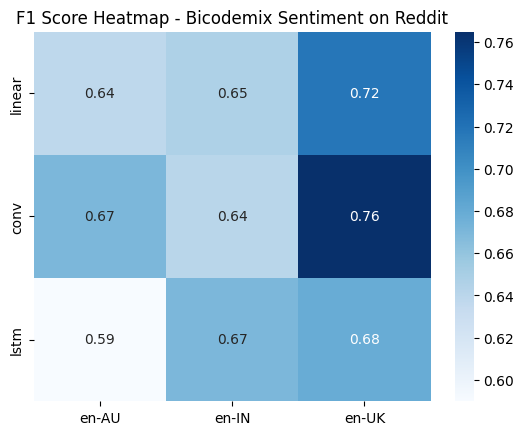

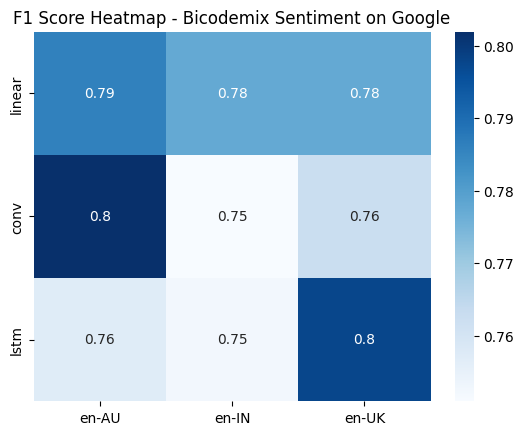

In [ ]:
import seaborn as sns

plt.figure()
data = np.array([v['f1'] for k,v in results.items() if k[2]=='Reddit']).reshape(3,3)
sns.heatmap(
        data,
        annot=True,
        yticklabels=['linear', 'conv', 'lstm'],
        xticklabels=['en-AU', 'en-IN', 'en-UK'],
        cmap='Blues'
    )
plt.title(f'F1 Score Heatmap - Bicodemix Sentiment on Reddit')
plt.show()

plt.figure()
data = np.array([v['f1'] for k,v in results.items() if k[2]=='Google']).reshape(3,3)
sns.heatmap(
        data,
        annot=True,
        yticklabels=['linear', 'conv', 'lstm'],
        xticklabels=['en-AU', 'en-IN', 'en-UK'],
        cmap='Blues'
    )
plt.title(f'F1 Score Heatmap - Bicodemix Sentiment on Google')
plt.show()

## Test from only one model

In [42]:
results = {}

# run_id = 'bert-base-uncased_cross_talk_conv_bicodemix_PCGrad_2e-05'
# run_name = f"{training_dataset_name}_{CFG['classification_head']}"
# test_model = get_model(CFG, run_id, 30, IS_MULTITASK, device, CFG['classification_head'], run_name=run_name)

# run_id = f"bert-base-uncased_{CFG['classification_head']}_bicodemix_{CFG['train_dataset_CFG']['task']}_spatten"
# models_root_dir = "./artifacts/"
# test_model = get_model(CFG, run_id, 30, IS_MULTITASK, device, CFG['classification_head'], models_root_dir=models_root_dir, run_name=run_name)

if CFG['train_dataset_CFG'].get('variety', None) == None and use_spAtten:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['task']}_spatten"
elif use_spAtten:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['variety']}_{CFG['train_dataset_CFG']['task']}_spatten"
elif CFG['train_dataset_CFG'].get('variety', None) == None:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['task']}"
else:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['variety']}_{CFG['train_dataset_CFG']['task']}"
test_model = get_model(CFG, run_id, 30, IS_MULTITASK, device, CFG['classification_head'], run_name=run_name)


labels_count = {}
for t, cs in train_ds.get_label_count().items():
    if t in CFG['train_dataset_CFG']['task'].lower():
        labels_count[t] = [c for c in cs.values()]
print(f'Label counts: {labels_count}')

for variety in ['en-AU', 'en-IN', 'en-UK']:
    print(f"Testing on variety: {variety}")
    for source, task in [('Reddit', 'sentiment'), ('Google', 'sentiment'), ('Reddit', 'sarcasm')]:
        if task not in CFG['train_dataset_CFG']['task'].lower():
            continue

        print(f"\tTesting on {source} for task: {task}")

        dataset_CFG = CFG['valid_dataset_CFG'].copy()
        dataset_CFG['variety'] = variety
        dataset_CFG['source'] = source
        dataset_CFG['task'] = task

        from dataset.besstie import dataset_besstie

        test_ds = dataset_besstie.BesstieDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            min_length=1,
            max_length=200,
        )

        test_loader = torch.utils.data.DataLoader(
            test_ds,
            batch_size=CFG['batch_size'],
            shuffle=False
        )
        print(f"\t\tTest dataset size: {len(test_ds)}")
        if IS_MULTITASK and use_spAtten:
            if task == 'sentiment':
                weights = labels_count[task].copy()
                sum_weights = sum(weights)
                weights.append(0)
                weights.append(0)
            elif task == 'sarcasm':
                weights = [0, 0, 0] + labels_count[task].copy()
            criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_weights for sw in weights], dtype=torch.float).to(device)
            )
        elif IS_MULTITASK:
            weights = labels_count[task]
            sum_weights = sum(weights)
            criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_weights for sw in weights], dtype=torch.float).to(device)
            )
        else:
            weights = labels_count[list(labels_count.keys())[0]]
            criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
            )

        test_loss, test_acc, test_f1 = testing(test_model, task, test_loader, criterion, device)

        results[(variety, source, task)] = {
            'loss': test_loss,
            'acc': test_acc,
            'f1': test_f1
        }


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


epoch/step,30
epoch/train_acc,1
epoch/train_loss,0.00024
epoch/val_acc,0.50578
epoch/val_f1,0.55826
epoch/val_loss,3.42305


wandb: Downloading large artifact 'bert-base-uncased_cross_talk_conv_bicodemix_sarcasm-sentiment_spatten:epoch_30', 1248.80MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:30.3 (41.2MB/s)


Label counts: {'sentiment': [192, 161, 141], 'sarcasm': [397, 97]}
Testing on variety: en-AU
	Testing on Reddit for task: sentiment
		Test dataset size: 241
	Testing on Google for task: sentiment
		Test dataset size: 130
	Testing on Reddit for task: sarcasm
		Test dataset size: 241
Testing on variety: en-IN
	Testing on Reddit for task: sentiment
		Test dataset size: 230
	Testing on Google for task: sentiment
		Test dataset size: 225
	Testing on Reddit for task: sarcasm
		Test dataset size: 230
Testing on variety: en-UK
	Testing on Reddit for task: sentiment
		Test dataset size: 138
	Testing on Google for task: sentiment
		Test dataset size: 248
	Testing on Reddit for task: sarcasm
		Test dataset size: 141


In [43]:
results

{('en-AU', 'Reddit', 'sentiment'): {'loss': 5.130200500269571,
  'acc': 0.46473029045643155,
  'f1': 0.5532981634431585},
 ('en-AU', 'Google', 'sentiment'): {'loss': 4.787650318706737,
  'acc': 0.5230769230769231,
  'f1': 0.5714285714285714},
 ('en-AU', 'Reddit', 'sarcasm'): {'loss': nan,
  'acc': 0.5809128630705395,
  'f1': 0.4876565967086348},
 ('en-IN', 'Reddit', 'sentiment'): {'loss': 6.1545406456651355,
  'acc': 0.4391304347826087,
  'f1': 0.5204117845318108},
 ('en-IN', 'Google', 'sentiment'): {'loss': 4.7019123003400605,
  'acc': 0.5066666666666667,
  'f1': 0.5560157232704402},
 ('en-IN', 'Reddit', 'sarcasm'): {'loss': nan,
  'acc': 0.7739130434782608,
  'f1': 0.7707101449275362},
 ('en-UK', 'Reddit', 'sentiment'): {'loss': 5.807108865843879,
  'acc': 0.41304347826086957,
  'f1': 0.5407457449382915},
 ('en-UK', 'Google', 'sentiment'): {'loss': 5.192752245933779,
  'acc': 0.43548387096774194,
  'f1': 0.4927656980288559},
 ('en-UK', 'Reddit', 'sarcasm'): {'loss': nan,
  'acc': 0.6

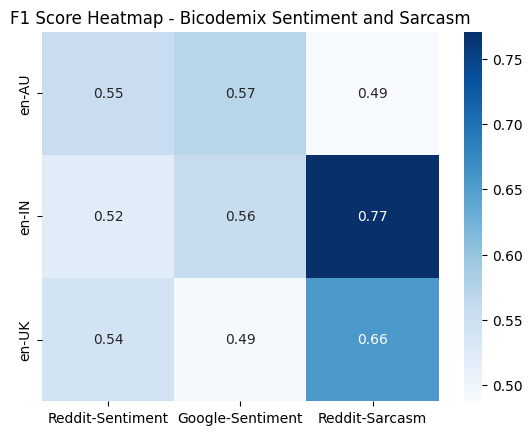

In [44]:
import seaborn as sns

plt.figure()
data = np.array([v['f1'] for k,v in results.items()]).reshape(3,3)
sns.heatmap(
        data,
        annot=True,
        # xticklabels=['Reddit'],
        # xticklabels=['Reddit-Sentiment', 'Google-Sentiment'],
        xticklabels=['Reddit-Sentiment', 'Google-Sentiment', 'Reddit-Sarcasm'],
        yticklabels=['en-AU', 'en-IN', 'en-UK'],
        cmap='Blues'
    )
plt.title(f'F1 Score Heatmap - Bicodemix Sentiment and Sarcasm')
plt.show()